<a href="https://colab.research.google.com/github/RA2112704010006/FML/blob/main/T4RegressionAbhayShaji.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# Load libraries
!pip install yfinance
import yfinance as yf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

# Libraries for Statistical Models
import statsmodels.api as sm

# Libraries for Saving the Model
from pickle import dump, load

# Get the data by webscapping using pandas datareader
return_period = 21

stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

# Use yfinance to fetch stock data
stk_data = yf.download(stk_tickers)

# Ensure the datetime index is timezone-naive
stk_data.index = stk_data.index.tz_localize(None)

# Fetch currency and index data
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

# Ensure the datetime indices are timezone-naive
ccy_data.index = ccy_data.index.tz_localize(None)
idx_data.index = idx_data.index.tz_localize(None)

# Calculate dependent variable
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1] + '_pred'

# Calculate independent variables
X1 = np.log(stk_data.loc[:, ('Adj Close', ['GOOGL', 'IBM'])]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

# Lagged differences of Y
X4 = pd.concat([Y.diff(i) for i in [21, 63, 126, 252]], axis=1).dropna()
X4.columns = ['1M', '3M', '6M', '1Y']

# Combine all independent variables
X = pd.concat([X1, X2, X3, X4], axis=1)

# Create final dataset
dataset = pd.concat([Y, X], axis=1).dropna()
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]


[*********************100%***********************]  3 of 3 completed


In [19]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')


#### Converting the data to supervised regression format
All the predictor variables are changed to lagged variable, as the t-1 value of the lagged variable will be used for prediction.

In [20]:
def series_to_supervised(data, lag=1):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(lag, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (df.columns[j], i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg = pd.DataFrame(data.iloc[:,0]).join(agg)
    agg.dropna(inplace=True)
    return agg

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [21]:
# shape
dataset.shape

(1144, 12)

In [22]:
# peek at data
pd.set_option('display.width', 100)
dataset.head(2)

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,1M,3M,6M,1Y
2019-10-03,0.053156,0.006038,0.040962,0.004506,0.016274,-0.009285,-0.005877,0.098296,0.063013,0.089183,-0.017901,0.128340
2019-10-04,0.045503,-0.001015,0.014228,-0.000468,-0.002272,-0.008094,-0.005795,0.046241,0.059379,0.062216,-0.000388,0.129228


In [23]:
# types
pd.set_option('display.max_rows', 500)
dataset.dtypes

,0
MSFT_pred,float64
GOOGL,float64
IBM,float64
DEXJPUS,float64
DEXUSUK,float64
SP500,float64
DJIA,float64
VIXCLS,float64
1M,float64
3M,float64


In [25]:
# Set the precision for floating-point numbers
pd.set_option('display.precision', 3)

# Describe the dataset
dataset.describe()


,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,1M,3M,6M,1Y
count,1144.000,1144.000,1144.000,1144.000,1.144e+03,1144.000,1144.000,1.144e+03,1.144e+03,1.144e+03,1144.000,1.144e+03
mean,0.020,0.018,0.009,0.006,4.681e-04,0.010,0.006,-1.467e-04,-8.416e-04,-5.179e-04,-0.001,-3.419e-04
std,0.071,0.081,0.076,0.025,2.502e-02,0.056,0.056,2.684e-01,1.094e-01,1.008e-01,0.103,9.555e-02
min,-0.302,-0.351,-0.461,-0.094,-1.207e-01,-0.400,-0.444,-7.838e-01,-4.272e-01,-3.467e-01,-0.327,-4.098e-01
25%,-0.026,-0.023,-0.035,-0.006,-1.481e-02,-0.012,-0.017,-1.565e-01,-6.849e-02,-7.187e-02,-0.073,-6.242e-02
50%,0.028,0.030,0.013,0.006,7.162e-04,0.021,0.012,-1.274e-02,1.373e-03,-1.133e-03,-0.001,-3.865e-04
75%,0.067,0.067,0.055,0.020,1.718e-02,0.042,0.034,1.251e-01,6.847e-02,6.436e-02,0.068,6.220e-02
max,0.244,0.211,0.230,0.083,9.455e-02,0.203,0.214,1.799e+00,5.407e-01,3.619e-01,0.292,2.856e-01


<a id='3'></a>
## 4. Data Preparation

<a id='3.1'></a>
## 4.1. Data Cleaning
Check for the NAs in the rows, either drop them or fill them with the mean of the column

In [26]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


Given that there are null values drop the rown contianing the null values.

In [27]:
# Drop the rows containing NA
#dataset.dropna(axis=0)
# Fill na with 0
#dataset.fillna('0')

#Filling the NAs with the mean of the column.
#dataset['col'] = dataset['col'].fillna(dataset['col'].mean())

<a id='3.3'></a>
## 4.3. Feature Selection


In [28]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest(k=5)
bestfeatures

SelectKBest(k=5)

In [29]:
type(dataset)

pandas.core.frame.DataFrame

In [30]:
Y= dataset["MSFT_pred"]
X = dataset.loc[:, dataset.columns != 'MSFT_pred']
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

     Specs  Score
0    GOOGL    NaN
1      IBM    NaN
2  DEXJPUS    NaN
3  DEXUSUK    NaN
4    SP500    NaN
5     DJIA    NaN
6   VIXCLS    NaN
7       1M    NaN
8       3M    NaN
9       6M    NaN


As it can be seen from the result above that t-1 is an important feature

<a id='3.4'></a>
## 4.4. Data Transformation

<a id='3.4.1'></a>
### 4.4.1. Rescale Data


In [31]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = pd.DataFrame(scaler.fit_transform(X))
# summarize transformed data
rescaledX.head(5)

,0,1,2,3,4,5,6,7,8,9,10
0,0.635,0.726,0.557,0.636,0.648,0.666,0.342,0.506,0.615,0.499,0.774
1,0.623,0.687,0.528,0.550,0.650,0.667,0.321,0.503,0.577,0.528,0.775
2,0.628,0.674,0.545,0.569,0.641,0.657,0.371,0.510,0.575,0.539,0.751
3,0.602,0.623,0.527,0.499,0.615,0.637,0.413,0.517,0.563,0.543,0.736
4,0.620,0.612,0.536,0.508,0.630,0.643,0.382,0.469,0.556,0.506,0.692


<a id='3.4.2'></a>
### 4.4.2. Standardize Data
Standardization is a useful technique to transform attributes with a Gaussian distribution and
differing means and standard deviations to a standard Gaussian distribution with a mean of
0 and a standard deviation of 1.

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
StandardisedX = pd.DataFrame(scaler.fit_transform(X))
# summarize transformed data
StandardisedX.head(5)

,0,1,2,3,4,5,6,7,8,9,10
0,-0.152,0.421,-0.080,0.632,-0.340,-0.216,0.367,0.584,0.890,-0.160,1.347
1,-0.240,0.067,-0.279,-0.110,-0.319,-0.214,0.173,0.551,0.623,0.010,1.357
2,-0.207,-0.055,-0.163,0.056,-0.415,-0.326,0.651,0.616,0.609,0.079,1.184
3,-0.384,-0.519,-0.291,-0.546,-0.693,-0.565,1.058,0.680,0.526,0.103,1.072
4,-0.261,-0.622,-0.227,-0.474,-0.537,-0.490,0.761,0.254,0.478,-0.117,0.750


<a id='3.4.3'></a>
### 4.4.1. Normalize Data
Normalizing in scikit-learn refers to rescaling each observation (row) to have a length of 1 (called
a unit norm or a vector with the length of 1 in linear algebra).

In [33]:
from sklearn.preprocessing import Normalizer
scaler = Normalizer().fit(X)
NormalizedX = pd.DataFrame(scaler.fit_transform(X))
# summarize transformed data
NormalizedX.head(5)

,0,1,2,3,4,5,6,7,8,9,10
0,0.030,0.204,0.022,0.081,-0.046,-0.029,0.488,0.313,0.443,-0.089,0.638
1,-0.006,0.087,-0.003,-0.014,-0.050,-0.036,0.284,0.364,0.382,-0.002,0.793
2,0.007,0.022,0.011,0.008,-0.059,-0.053,0.768,0.292,0.268,0.029,0.496
3,-0.040,-0.094,-0.002,-0.041,-0.091,-0.079,0.889,0.230,0.164,0.029,0.320
4,-0.012,-0.165,0.004,-0.050,-0.089,-0.093,0.892,0.118,0.208,-0.059,0.312


\<a id='4'></a>
# 5. Evaluate Algorithms and Model

<a id='4.1'></a>
## 5.1. Train Test Split

In [34]:
# split out validation dataset for the end

validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
seed = 7
# X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

#In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.

train_size = int(len(X) * (1-validation_size))
X_train, X_validation = X[0:train_size], X[train_size:len(X)]
Y_train, Y_validation = Y[0:train_size], Y[train_size:len(X)]

<a id='4.2'></a>
## 5.2. Test Options and Evaluation Metrics


In [40]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [41]:
# Initialize and train the model
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, Y_train)


DecisionTreeRegressor(random_state=42)

In [42]:
# Make predictions
Y_pred = model.predict(X_validation)


In [43]:
# Evaluate the model
mse = mean_squared_error(Y_validation, Y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 0.0018941448192515236


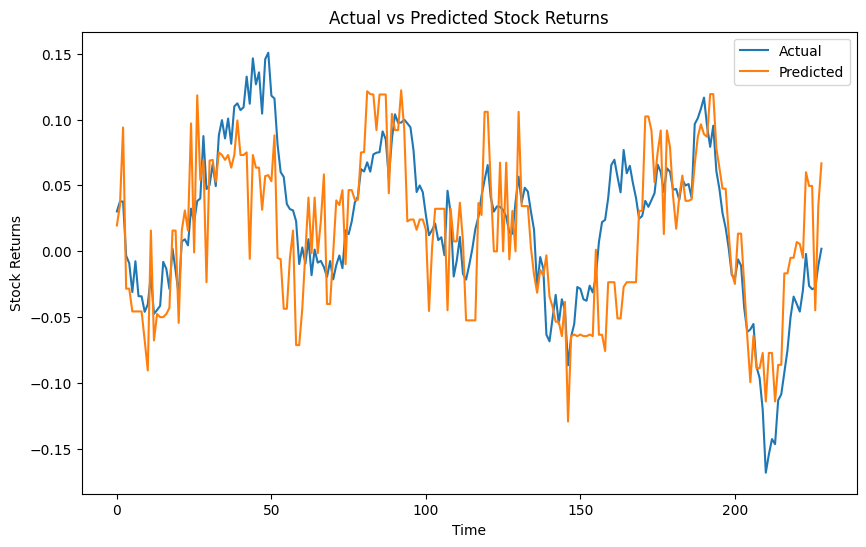

In [44]:
# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(Y_validation.values, label='Actual')
plt.plot(Y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Returns')
plt.title('Actual vs Predicted Stock Returns')
plt.legend()
plt.show()


In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(Y_validation, Y_pred)
print(f'Mean Squared Error: {mse}')

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(Y_validation, Y_pred)
print(f'Mean Absolute Error: {mae}')

# Calculate R-squared (coefficient of determination)
r2 = r2_score(Y_validation, Y_pred)
print(f'R-squared: {r2}')


Mean Squared Error: 0.0018941448192515236
Mean Absolute Error: 0.03464636008216346
R-squared: 0.4410284026862584
